In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Heat Equation Solver using PyTorch
## Centered Differences in Space + Implicit Euler in Time

This notebook implements the 1D heat equation on a $[0,1]$ periodic domain:
$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

**Discretization:**
- Space: Centered finite differences
- Time: Implicit Euler (backward Euler)
- Periodic boundary conditions: $u(0) = u(1)$

**Implicit Euler scheme:**
$$\frac{u^{n+1} - u^n}{\Delta t} = \alpha \frac{\partial^2 u^{n+1}}{\partial x^2}$$

This leads to a linear system at each time step:
$$(I - \alpha \Delta t \cdot D_{xx}) u^{n+1} = u^n$$

## Build Centered Difference Matrix for Periodic Domain

For a periodic domain with $N$ grid points and spacing $h = L/N$, the centered difference approximation is:
$$\frac{\partial^2 u}{\partial x^2}\bigg|_i \approx \frac{u_{i-1} - 2u_i + u_{i+1}}{h^2}$$

The matrix $D_{xx}$ has the structure:
$$D_{xx} = \frac{1}{h^2} \begin{bmatrix}
-2 & 1 & 0 & \cdots & 0 & 1 \\
1 & -2 & 1 & \cdots & 0 & 0 \\
\vdots & \ddots & \ddots & \ddots & \vdots & \vdots \\
1 & 0 & 0 & \cdots & 1 & -2
\end{bmatrix}$$

Note the periodic wrapping in the corners.

In [18]:
def build_centered_diff_matrix_periodic(N, device='cpu'):
    """
    Build the centered finite difference matrix for the second derivative
    on a periodic domain.
    
    Parameters:
    -----------
    N : int
        Number of spatial grid points
    dx : float
        Spatial grid spacing - computed as 1./N for domain [0,1]
    device : str or torch.device
        Device to place the matrix on
        
    Returns:
    --------
    D_xx : torch.Tensor
        Second derivative matrix of shape (N, N)
    """
    dx = 1./N
    # Stencil coefficients for centered difference
    coeffs = torch.tensor([1.0, -2.0, 1.0], device=device) / (dx ** 2)
    
    # Build tridiagonal matrix
    # main_diag = coeffs[1] * torch.ones(N, device=device)
    # off_diag = coeffs[0] * torch.ones(N - 1, device=device)
    # D_xx = torch.diag(main_diag) + torch.diag(off_diag, diagonal=1) + torch.diag(off_diag, diagonal=-1)

    # Or compute with list comprehension (use sum(), not torch.sum() for list of tensors)
    D_xx = sum([coeffs[i]*torch.diag(torch.ones(N - abs(i), device=device), diagonal=i) for i in [-1,0,1]])
    
    # Add periodic boundary conditions (corners)
    D_xx[0, -1] = coeffs[0]
    D_xx[-1, 0] = coeffs[-1]
    
    return D_xx

### Validation
To check our implementation, we'll always print out and make sure things look good.

In [20]:
D_xx = build_centered_diff_matrix_periodic(8, device=device)
print(D_xx.cpu().numpy())

[[  64. -128.    0.    0.    0.    0.    0.   64.]
 [  64.   64. -128.    0.    0.    0.    0.    0.]
 [   0.   64.   64. -128.    0.    0.    0.    0.]
 [   0.    0.   64.   64. -128.    0.    0.    0.]
 [   0.    0.    0.   64.   64. -128.    0.    0.]
 [   0.    0.    0.    0.   64.   64. -128.    0.]
 [   0.    0.    0.    0.    0.   64.   64. -128.]
 [  64.    0.    0.    0.    0.    0.   64.   64.]]


## Heat Equation Solver Class

Implements the implicit Euler time-stepping scheme for the heat equation.

In [30]:
class HeatEquationSolver:
    """
    Solves the 1D heat equation on a periodic domain using:
    - Centered differences in space
    - Implicit Euler in time
    """
    
    def __init__(self, N, alpha, dt, device='cpu'):
        """
        Parameters:
        -----------
        N : int
            Number of spatial grid points
        alpha : float
            Thermal diffusivity coefficient
        dt : float
            Time step size
        device : str or torch.device
            Device to run computations on
        """
        self.N = N
        self.alpha = alpha
        self.dt = dt
        self.device = device
        
        # Spatial grid
        self.dx = 1.0 / N
        self.x = torch.linspace(0, 1.0 - self.dx, N, device=device)
        
        # Build the spatial derivative matrix
        self.D_xx = build_centered_diff_matrix_periodic(N, device=device)
        
        # Build the implicit Euler system matrix: A = I - alpha * dt * D_xx
        self.A = torch.eye(N, device=device) - alpha * dt * self.D_xx
        
        # For efficient solving, we can precompute LU decomposition
        # Note: PyTorch's torch.linalg.solve is efficient for repeated solves
        
    def step(self, u):
        """
        Take one implicit Euler time step.
        
        Parameters:
        -----------
        u : torch.Tensor
            Current solution of shape (N,)
            
        Returns:
        --------
        u_new : torch.Tensor
            Solution at next time step
        """
        # Solve: (I - alpha * dt * D_xx) u_new = u
        u_new = torch.linalg.solve(self.A, u)
        return u_new
    
    def solve(self, u0, num_steps):
        """
        Solve the heat equation for multiple time steps.
        
        Parameters:
        -----------
        u0 : torch.Tensor
            Initial condition of shape (N,)
        num_steps : int
            Number of time steps to take
            
        Returns:
        --------
        u_history : torch.Tensor
            Solution history of shape (num_steps+1, N)
        """
        u_history = torch.zeros(num_steps + 1, self.N, device=self.device)
        u_history[0] = u0
        
        u = u0.clone()
        for i in range(num_steps):
            u = self.step(u)
            u_history[i + 1] = u
            
        return u_history

## Test Case: Gaussian Initial Condition

We'll test the solver with a Gaussian initial condition and visualize the diffusion process.

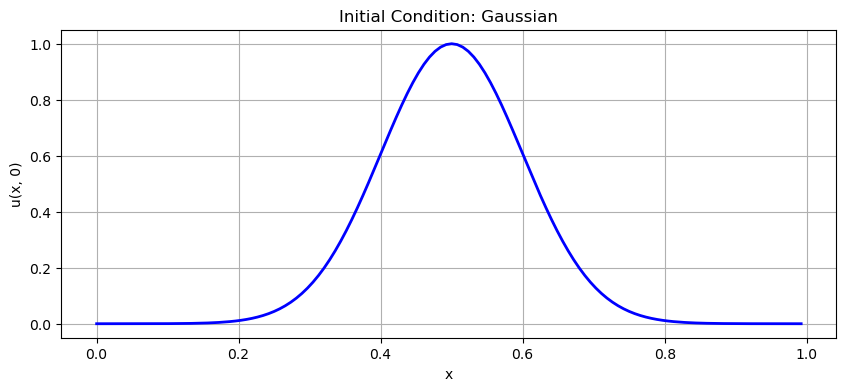

Spatial points: 128
Spatial step: 0.007812
Time step: 0.01
Number of time steps: 2


In [34]:
# Problem parameters
N = 64                  # Number of spatial grid points
alpha = 0.01              # Thermal diffusivity
dt = 0.01                # Time step
T_final = 5*dt           # Final time
num_steps = int(T_final / dt)

# Initialize solver
solver = HeatEquationSolver(N, alpha, dt, device=device)

# Initial condition: Gaussian
x = solver.x
u0 = torch.exp(-((x - 0.5) ** 2) / 0.02)

# Visualize initial condition
plt.figure(figsize=(10, 4))
plt.plot(x.cpu().numpy(), u0.cpu().numpy(), 'b-', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x, 0)')
plt.title('Initial Condition: Gaussian')
plt.grid(True)
plt.show()

print(f"Spatial points: {N}")
print(f"Spatial step: {solver.dx:.6f}")
print(f"Time step: {dt}")
print(f"Number of time steps: {num_steps}")

## Solve the Heat Equation

In [35]:
# Solve
start_time = time.time()
u_history = solver.solve(u0, num_steps)
end_time = time.time()

print(f"Simulation completed in {end_time - start_time:.4f} seconds")
print(f"Solution shape: {u_history.shape}")

Simulation completed in 0.0070 seconds
Solution shape: torch.Size([3, 128])


## Visualize the Solution Evolution

In [36]:
u_history.shape

torch.Size([3, 128])

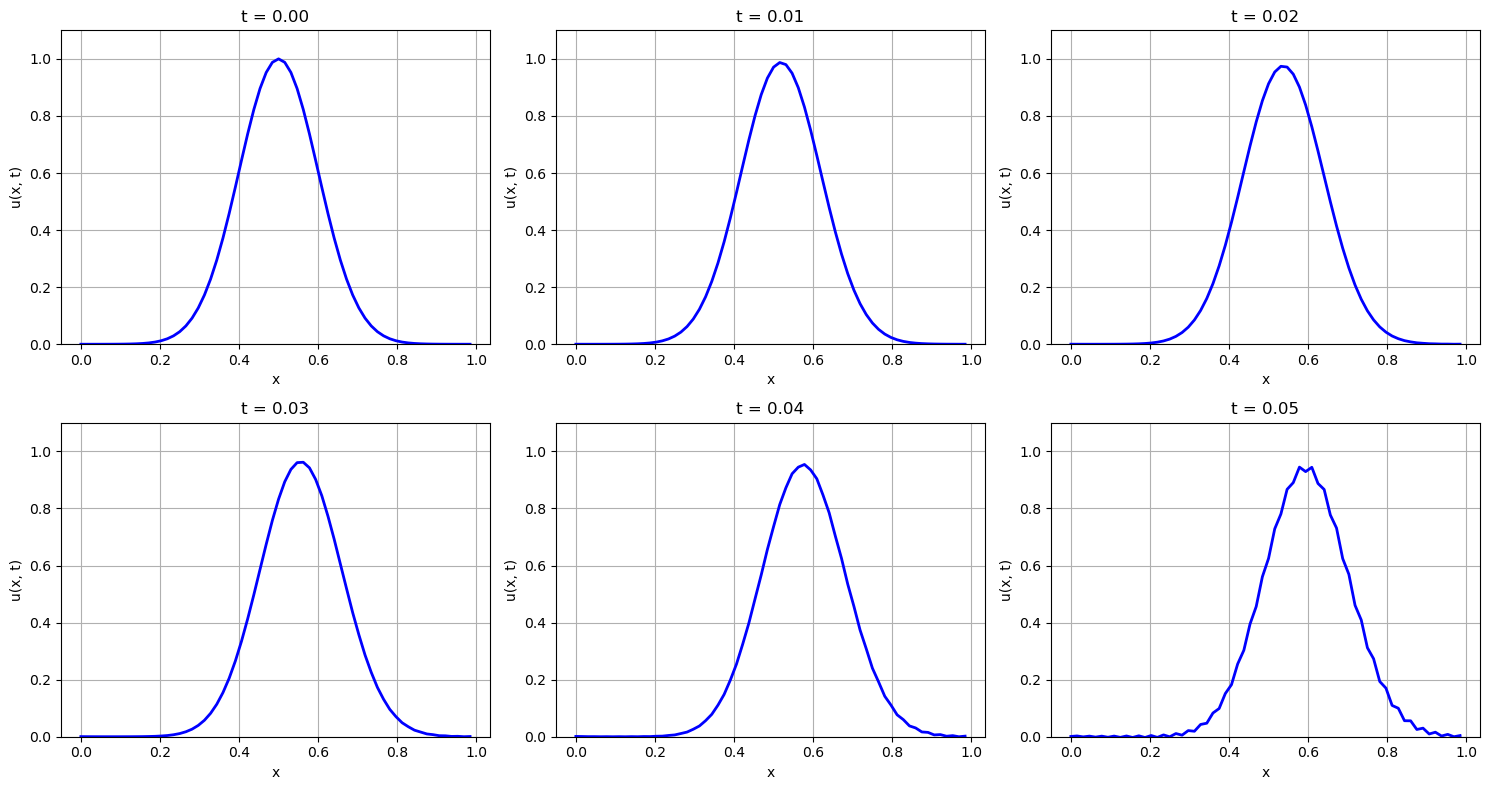

In [51]:
# Plot solution at several time points
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# time_indices = [0, num_steps // 5, 2 * num_steps // 5, 
                # 3 * num_steps // 5, 4 * num_steps // 5, num_steps]

time_indices = [0,1,2,3,4,5]

for idx, t_idx in enumerate(time_indices):
    ax = axes[idx]
    t = t_idx * dt
    u = u_history[t_idx].cpu().numpy()
    
    ax.plot(x.cpu().numpy(), u, 'b-', linewidth=2)
    ax.set_xlabel('x')
    ax.set_ylabel('u(x, t)')
    ax.set_title(f't = {t:.2f}')
    ax.grid(True)
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

## Space-Time Plot

In [ ]:
# Space-time contour plot
plt.figure(figsize=(12, 6))

# Subsample for visualization
plot_every = max(1, num_steps // 100)
u_plot = u_history[::plot_every].cpu().numpy()
t_plot = np.arange(0, num_steps + 1, plot_every) * dt

X, T = np.meshgrid(x.cpu().numpy(), t_plot)

plt.contourf(X, T, u_plot, levels=20, cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heat Equation Solution: Space-Time Evolution')
plt.show()

## Verification: Check Conservation

For the heat equation on a periodic domain, the total integral $\int_0^L u(x,t) dx$ should be conserved.

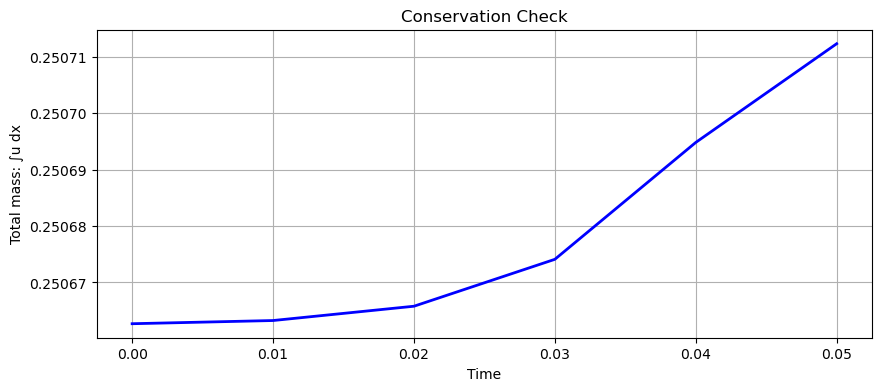

Initial mass: 0.250663
Final mass: 0.250712
Relative change: 0.019796%


In [50]:
# Compute total integral over time (using trapezoidal rule)
total_mass = torch.sum(u_history, dim=1) * solver.dx

plt.figure(figsize=(10, 4))
plt.plot(np.arange(num_steps + 1) * dt, total_mass.cpu().numpy(), 'b-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Total mass: ∫u dx')
plt.title('Conservation Check')
plt.grid(True)
plt.show()

print(f"Initial mass: {total_mass[0].item():.6f}")
print(f"Final mass: {total_mass[-1].item():.6f}")
print(f"Relative change: {abs(total_mass[-1] - total_mass[0]) / total_mass[0] * 100:.6f}%")

## Toward Learnable Finite Difference Stencils

This baseline implementation uses the standard centered difference stencil:
$$\frac{\partial^2 u}{\partial x^2}\bigg|_i \approx \frac{1}{h^2}[1, -2, 1]$$

**Next steps for making stencils learnable:**
1. Replace fixed coefficients `[1, -2, 1]` with learnable parameters
2. Extend stencil width (e.g., 5-point, 7-point stencils)
3. Add constraints to preserve properties:
   - Consistency (stencil → derivative as h → 0)
   - Stability
   - Conservation
4. Train by minimizing error against reference solutions or matching target PDEs

### Example: Parameterized 3-point stencil
Instead of fixed `[1, -2, 1]`, use `[w_{-1}, w_0, w_1]` where $w$ are learnable.

In [ ]:
class LearnableStencilMatrix(torch.nn.Module):
    """
    Example: A learnable finite difference matrix.
    Uses a 3-point stencil with learnable coefficients.
    """
    
    def __init__(self, N, dx, device='cpu'):
        super().__init__()
        self.N = N
        self.dx = dx
        self.device = device
        
        # Initialize stencil coefficients close to standard centered difference
        # [w_{-1}, w_0, w_1] initialized to [1, -2, 1] / dx^2
        self.stencil = torch.nn.Parameter(
            torch.tensor([1.0, -2.0, 1.0], device=device) / (dx ** 2)
        )
        
    def forward(self):
        """
        Build the differentiation matrix using current stencil coefficients.
        """
        w_minus, w_center, w_plus = self.stencil
        
        # Build tridiagonal + periodic
        main_diag = w_center * torch.ones(self.N, device=self.device)
        off_diag = w_plus * torch.ones(self.N - 1, device=self.device)
        off_diag_lower = w_minus * torch.ones(self.N - 1, device=self.device)
        
        D_xx = (torch.diag(main_diag) + 
                torch.diag(off_diag, diagonal=1) + 
                torch.diag(off_diag_lower, diagonal=-1))
        
        # Periodic boundaries
        D_xx[0, -1] = w_minus
        D_xx[-1, 0] = w_plus
        
        return D_xx

# Example instantiation
learnable_stencil = LearnableStencilMatrix(N=10, dx=0.1, device=device)
D_matrix = learnable_stencil.forward()

print("Learnable stencil coefficients:", learnable_stencil.stencil)
print("\nMatrix built from learnable stencil (first 5x5 block):")
print(D_matrix[:5, :5])
print("\nPeriodic boundary terms:")
print(f"  Top-right corner D[0, -1] = {D_matrix[0, -1].item():.4f} (should be w_minus)")
print(f"  Bottom-left corner D[-1, 0] = {D_matrix[-1, 0].item():.4f} (should be w_plus)")
print("\nFull first row (showing periodic wrap):")
print(D_matrix[0, :])
print("\nFull last row (showing periodic wrap):")
print(D_matrix[-1, :])